In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/microsoft-catsvsdogs-dataset/readme[1].txt
/kaggle/input/microsoft-catsvsdogs-dataset/MSR-LA - 3467.docx
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/7981.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/6234.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/1269.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/3863.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/6241.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/10304.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/623.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/2193.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/11925.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/3750.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/11378.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/2008.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/10730.jpg
/kaggle/input/micros

In [2]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split
import warnings
import logging
warnings.filterwarnings("ignore")
logging.getLogger("PIL").setLevel(logging.ERROR)
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import numpy as np
import random
import os
import plotly.express as px

2025-07-31 08:55:15.555554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753952115.773418      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753952115.833725      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class_names = ['Cat', 'Dog'] 

n_dogs = len(os.listdir('/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog'))
n_cats = len(os.listdir('/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat'))
n_images = [n_cats, n_dogs]
px.pie(names=class_names, values=n_images)

In [4]:
# Original dataset path (adjust if needed)
original_dir = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages'

# Target base directory
base_dir = '/kaggle/working/cats_dogs_split'

# Create target directories
for split in ['train', 'val', 'test']:
    for category in ['Cat', 'Dog']:
        os.makedirs(os.path.join(base_dir, split, category), exist_ok=True)

# Function to split and copy files
def split_and_copy(class_name):
    src_dir = os.path.join(original_dir, class_name)
    all_files = [f for f in os.listdir(src_dir) if f.endswith('.jpg')]
    random.shuffle(all_files)

    # Remove corrupt images
    all_files_clean = []
    for file in all_files:
        try:
            with open(os.path.join(src_dir, file), 'rb') as f:
                f.read()
            all_files_clean.append(file)
        except:
            continue
            # Train, val, test split
    train_files, temp_files = train_test_split(all_files_clean, test_size=0.2, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    for file in train_files:
        shutil.copy(os.path.join(src_dir, file), os.path.join(base_dir, 'train', class_name, file))
    for file in val_files:
        shutil.copy(os.path.join(src_dir, file), os.path.join(base_dir, 'val', class_name, file))
    for file in test_files:
        shutil.copy(os.path.join(src_dir, file), os.path.join(base_dir, 'test', class_name, file))

# Split both classes
split_and_copy('Cat')
split_and_copy('Dog')

In [5]:
import os

# Path to the base split directory
base_dir = '/kaggle/working/cats_dogs_split'

# Function to count files in each category
def count_images(split):
    cat_dir = os.path.join(base_dir, split, 'Cat')
    dog_dir = os.path.join(base_dir, split, 'Dog')
    num_cats = len(os.listdir(cat_dir))
    num_dogs = len(os.listdir(dog_dir))
    total = num_cats + num_dogs
    print(f"{split.upper()} - Cats: {num_cats}, Dogs: {num_dogs}, Total: {total}")

# Print counts for all splits
for split in ['train', 'val', 'test']:
    count_images(split)

TRAIN - Cats: 10000, Dogs: 10000, Total: 20000
VAL - Cats: 1250, Dogs: 1250, Total: 2500
TEST - Cats: 1250, Dogs: 1250, Total: 2500


In [6]:
def load_dataset(directory):
    ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        image_size=(150, 150),
        batch_size=32,
        label_mode='binary'  # Good for binary classification
    )

    # Apply shuffle, prefetch and ignore errors properly
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    # Use .ignore_errors() directly
    return ds.ignore_errors()


train_ds = load_dataset('/kaggle/working/cats_dogs_split/train')
val_ds = load_dataset('/kaggle/working/cats_dogs_split/val')
test_ds = load_dataset('/kaggle/working/cats_dogs_split/test')

Found 20000 files belonging to 2 classes.


I0000 00:00:1753952299.041136      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753952299.041990      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 2500 files belonging to 2 classes.
Found 2500 files belonging to 2 classes.


In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

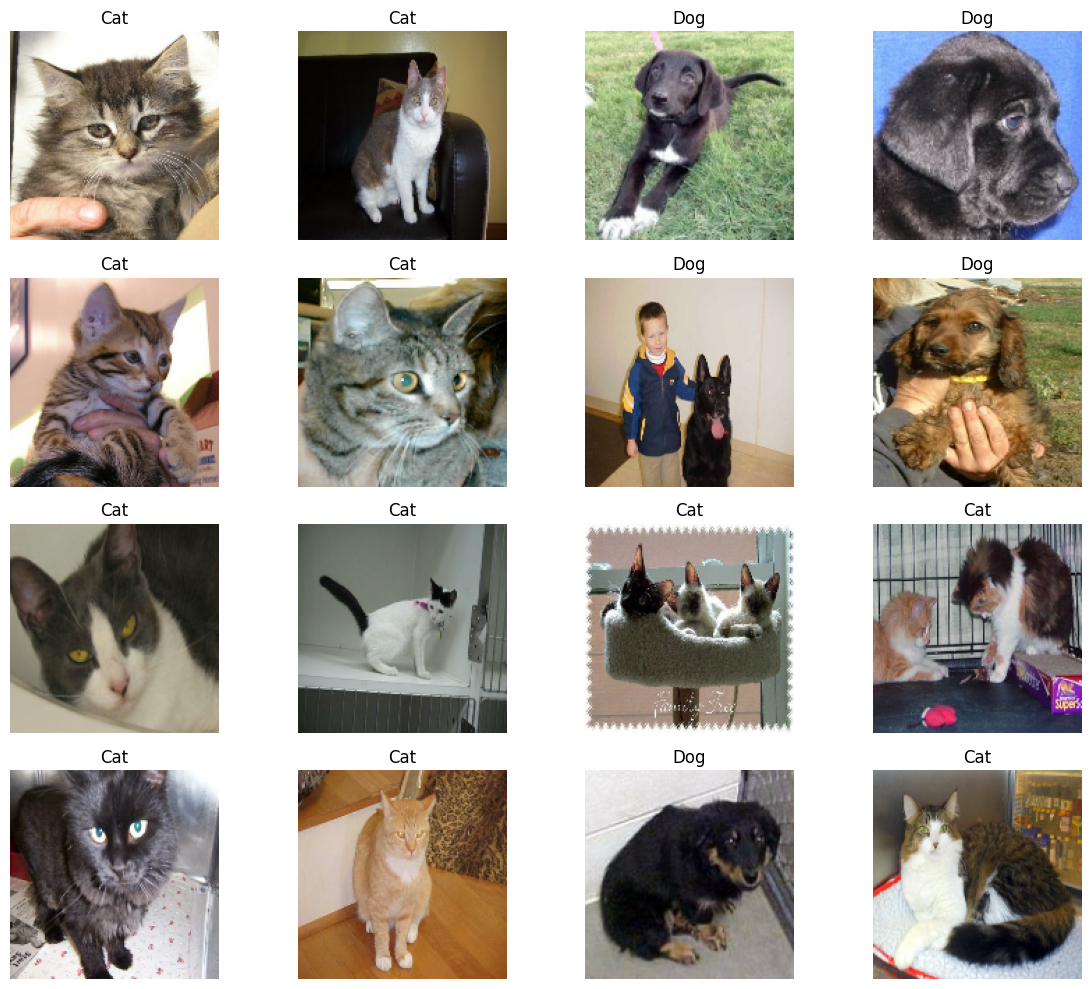

In [8]:
# Get one batch from the training dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 10))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = 'Dog' if labels[i].numpy() == 1 else 'Cat'
        plt.title(label)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    GlobalAveragePooling2D(),

    Dense(1024, activation='relu'),
    # Dense(2, activation='softmax')  # 2 classes: Cat & Dog
    # Dense(1, activation='softmax')  # 2 classes: Cat & Dog
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 69, 69, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 34, 34, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 30, 30, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 837,121 (3.19 MB)

 Trainable params: 837,121 (3.19 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

# Create the callback
early_stop = EarlyStopping(
    monitor='val_loss',      # Watch the validation loss
    patience=3,              # Stop if val_loss doesn't improve for 3 epochs
    restore_best_weights=True,  # Load best model weights
    verbose=1
)

# Train the model with the callback
history = model.fit(
    train_ds,
    epochs=50,  # Can be more, early stopping will cut it
    validation_data=val_ds,
    callbacks=[early_stop],   # ✅ Add your callback here
    verbose=1
)

Epoch 1/50


I0000 00:00:1753952306.964242     106 service.cc:148] XLA service 0x7cebfc04dd90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753952306.965018     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753952306.965039     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753952307.475798     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


      2/Unknown 13s 74ms/step - accuracy: 0.5391 - loss: 9.2078

I0000 00:00:1753952316.145151     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     77/Unknown 18s 69ms/step - accuracy: 0.5038 - loss: 2.6911

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


    113/Unknown 20s 69ms/step - accuracy: 0.5073 - loss: 2.1909

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


    134/Unknown 22s 69ms/step - accuracy: 0.5093 - loss: 2.0071

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


    289/Unknown 32s 69ms/step - accuracy: 0.5179 - loss: 1.4084

    363/Unknown 38s 69ms/step - accuracy: 0.5193 - loss: 1.2881

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


    371/Unknown 38s 69ms/step - accuracy: 0.5193 - loss: 1.2777

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


    463/Unknown 45s 69ms/step - accuracy: 0.5200 - loss: 1.1812

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


    473/Unknown 45s 69ms/step - accuracy: 0.5201 - loss: 1.1727

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


    500/Unknown 47s 69ms/step - accuracy: 0.5205 - loss: 1.1513

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


    526/Unknown 49s 69ms/step - accuracy: 0.5210 - loss: 1.1325

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


    619/Unknown 56s 70ms/step - accuracy: 0.5225 - loss: 1.0769

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 61s 79ms/step - accuracy: 0.5225 - loss: 1.0764 - val_accuracy: 0.6328 - val_loss: 0.6646
Epoch 2/50
 74/619 ━━━━━━━━━━━━━━━━━━━━ 39s 72ms/step - accuracy: 0.6129 - loss: 0.6671

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 93/619 ━━━━━━━━━━━━━━━━━━━━ 37s 72ms/step - accuracy: 0.6138 - loss: 0.6658

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


130/619 ━━━━━━━━━━━━━━━━━━━━ 35s 72ms/step - accuracy: 0.6147 - loss: 0.6641

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


288/619 ━━━━━━━━━━━━━━━━━━━━ 24s 73ms/step - accuracy: 0.6181 - loss: 0.6597

347/619 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - accuracy: 0.6175 - loss: 0.6593

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


364/619 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.6175 - loss: 0.6592

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


455/619 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.6184 - loss: 0.6576

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


467/619 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.6187 - loss: 0.6574

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


491/619 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.6192 - loss: 0.6568

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


531/619 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.6202 - loss: 0.6557

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6229 - loss: 0.6532

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.6229 - loss: 0.6532 - val_accuracy: 0.7012 - val_loss: 0.5899
Epoch 3/50
 88/619 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - accuracy: 0.6618 - loss: 0.6245

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 91/619 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - accuracy: 0.6623 - loss: 0.6241

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


136/619 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - accuracy: 0.6694 - loss: 0.6186

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


152/619 ━━━━━━━━━━━━━━━━━━━━ 36s 78ms/step - accuracy: 0.6713 - loss: 0.6168

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


284/619 ━━━━━━━━━━━━━━━━━━━━ 26s 78ms/step - accuracy: 0.6802 - loss: 0.6078

351/619 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.6825 - loss: 0.6054

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


364/619 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - accuracy: 0.6829 - loss: 0.6050

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


457/619 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.6854 - loss: 0.6019

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


468/619 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6857 - loss: 0.6016

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


487/619 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.6861 - loss: 0.6010

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


535/619 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.6871 - loss: 0.5996

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6890 - loss: 0.5973

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.6890 - loss: 0.5973 - val_accuracy: 0.7300 - val_loss: 0.5477
Epoch 4/50
 95/619 ━━━━━━━━━━━━━━━━━━━━ 38s 74ms/step - accuracy: 0.7115 - loss: 0.5588

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


136/619 ━━━━━━━━━━━━━━━━━━━━ 35s 74ms/step - accuracy: 0.7158 - loss: 0.5563

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


143/619 ━━━━━━━━━━━━━━━━━━━━ 35s 74ms/step - accuracy: 0.7162 - loss: 0.5561

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


300/619 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.7191 - loss: 0.5549

348/619 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.7196 - loss: 0.5547

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


361/619 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.7197 - loss: 0.5545

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


458/619 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.7212 - loss: 0.5529

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


470/619 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.7214 - loss: 0.5527

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


487/619 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.7217 - loss: 0.5523

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


524/619 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.7223 - loss: 0.5515

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7239 - loss: 0.5497

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 48s 78ms/step - accuracy: 0.7239 - loss: 0.5496 - val_accuracy: 0.7504 - val_loss: 0.5291
Epoch 5/50
 79/619 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - accuracy: 0.7568 - loss: 0.5196

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 95/619 ━━━━━━━━━━━━━━━━━━━━ 39s 76ms/step - accuracy: 0.7549 - loss: 0.5214

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


129/619 ━━━━━━━━━━━━━━━━━━━━ 37s 76ms/step - accuracy: 0.7522 - loss: 0.5229

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


133/619 ━━━━━━━━━━━━━━━━━━━━ 37s 76ms/step - accuracy: 0.7521 - loss: 0.5229

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


298/619 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - accuracy: 0.7478 - loss: 0.5239

352/619 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.7477 - loss: 0.5232

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


366/619 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.7478 - loss: 0.5229

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


466/619 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.7490 - loss: 0.5202

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


506/619 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.7495 - loss: 0.5191

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


524/619 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.7497 - loss: 0.5187

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7510 - loss: 0.5164

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.7510 - loss: 0.5164 - val_accuracy: 0.7316 - val_loss: 0.5727
Epoch 6/50
 84/619 ━━━━━━━━━━━━━━━━━━━━ 40s 75ms/step - accuracy: 0.7559 - loss: 0.5133

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 94/619 ━━━━━━━━━━━━━━━━━━━━ 39s 75ms/step - accuracy: 0.7559 - loss: 0.5130

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


132/619 ━━━━━━━━━━━━━━━━━━━━ 36s 75ms/step - accuracy: 0.7585 - loss: 0.5093

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


287/619 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - accuracy: 0.7662 - loss: 0.4974

351/619 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.7683 - loss: 0.4941

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


388/619 ━━━━━━━━━━━━━━━━━━━━ 17s 75ms/step - accuracy: 0.7695 - loss: 0.4921

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


466/619 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.7718 - loss: 0.4883

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


475/619 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.7721 - loss: 0.4879

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


502/619 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.7727 - loss: 0.4868

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


527/619 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.7733 - loss: 0.4858

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7751 - loss: 0.4828

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 48s 78ms/step - accuracy: 0.7752 - loss: 0.4828 - val_accuracy: 0.8056 - val_loss: 0.4312
Epoch 7/50
 75/619 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - accuracy: 0.8067 - loss: 0.4165

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 95/619 ━━━━━━━━━━━━━━━━━━━━ 39s 75ms/step - accuracy: 0.8038 - loss: 0.4226

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


130/619 ━━━━━━━━━━━━━━━━━━━━ 36s 75ms/step - accuracy: 0.8030 - loss: 0.4268

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


145/619 ━━━━━━━━━━━━━━━━━━━━ 35s 75ms/step - accuracy: 0.8026 - loss: 0.4281

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


287/619 ━━━━━━━━━━━━━━━━━━━━ 25s 76ms/step - accuracy: 0.7990 - loss: 0.4371

349/619 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.7986 - loss: 0.4381

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


393/619 ━━━━━━━━━━━━━━━━━━━━ 17s 76ms/step - accuracy: 0.7989 - loss: 0.4378

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


455/619 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.7994 - loss: 0.4369

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


472/619 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.7996 - loss: 0.4366

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


487/619 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.7997 - loss: 0.4363 

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


527/619 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.8001 - loss: 0.4358

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8008 - loss: 0.4347

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.8008 - loss: 0.4347 - val_accuracy: 0.8056 - val_loss: 0.4431
Epoch 8/50
 82/619 ━━━━━━━━━━━━━━━━━━━━ 40s 76ms/step - accuracy: 0.8345 - loss: 0.3869

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


103/619 ━━━━━━━━━━━━━━━━━━━━ 39s 76ms/step - accuracy: 0.8311 - loss: 0.3941

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


129/619 ━━━━━━━━━━━━━━━━━━━━ 37s 76ms/step - accuracy: 0.8293 - loss: 0.3973

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


291/619 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - accuracy: 0.8277 - loss: 0.3997

352/619 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.8276 - loss: 0.3995

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


375/619 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.8276 - loss: 0.3993

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


460/619 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.8280 - loss: 0.3979

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


485/619 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.8281 - loss: 0.3973

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


493/619 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.8281 - loss: 0.3972

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


523/619 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.8283 - loss: 0.3965

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8287 - loss: 0.3948

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.8287 - loss: 0.3947 - val_accuracy: 0.8204 - val_loss: 0.3984
Epoch 9/50
 76/619 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - accuracy: 0.8577 - loss: 0.3351

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 91/619 ━━━━━━━━━━━━━━━━━━━━ 40s 76ms/step - accuracy: 0.8553 - loss: 0.3403

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


132/619 ━━━━━━━━━━━━━━━━━━━━ 36s 76ms/step - accuracy: 0.8534 - loss: 0.3456

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


178/619 ━━━━━━━━━━━━━━━━━━━━ 33s 76ms/step - accuracy: 0.8517 - loss: 0.3489

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


285/619 ━━━━━━━━━━━━━━━━━━━━ 25s 76ms/step - accuracy: 0.8494 - loss: 0.3546

350/619 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.8486 - loss: 0.3561

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


363/619 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.8486 - loss: 0.3562

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


475/619 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.8491 - loss: 0.3546

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


491/619 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.8492 - loss: 0.3542

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


494/619 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.8492 - loss: 0.3541

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


531/619 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.8495 - loss: 0.3533

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8500 - loss: 0.3520

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.8500 - loss: 0.3520 - val_accuracy: 0.8016 - val_loss: 0.4424
Epoch 10/50
 74/619 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - accuracy: 0.8763 - loss: 0.3103

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 93/619 ━━━━━━━━━━━━━━━━━━━━ 39s 76ms/step - accuracy: 0.8728 - loss: 0.3151

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


134/619 ━━━━━━━━━━━━━━━━━━━━ 36s 76ms/step - accuracy: 0.8698 - loss: 0.3191

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


152/619 ━━━━━━━━━━━━━━━━━━━━ 35s 76ms/step - accuracy: 0.8693 - loss: 0.3195

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


289/619 ━━━━━━━━━━━━━━━━━━━━ 25s 76ms/step - accuracy: 0.8671 - loss: 0.3204

367/619 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.8667 - loss: 0.3200

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


466/619 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.8672 - loss: 0.3174

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


490/619 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.8674 - loss: 0.3168

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


524/619 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.8677 - loss: 0.3159

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8683 - loss: 0.3139

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.8683 - loss: 0.3139 - val_accuracy: 0.8328 - val_loss: 0.4049
Epoch 11/50
 81/619 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - accuracy: 0.8869 - loss: 0.2698

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 92/619 ━━━━━━━━━━━━━━━━━━━━ 40s 77ms/step - accuracy: 0.8854 - loss: 0.2734

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


127/619 ━━━━━━━━━━━━━━━━━━━━ 37s 77ms/step - accuracy: 0.8825 - loss: 0.2799

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


130/619 ━━━━━━━━━━━━━━━━━━━━ 37s 77ms/step - accuracy: 0.8823 - loss: 0.2802

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


294/619 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.8796 - loss: 0.2856

349/619 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.8793 - loss: 0.2857

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


363/619 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.8793 - loss: 0.2856

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


461/619 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.8799 - loss: 0.2838

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


470/619 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.8800 - loss: 0.2836

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


489/619 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.8801 - loss: 0.2833 

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


540/619 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.8805 - loss: 0.2823

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8808 - loss: 0.2814

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.8808 - loss: 0.2814 - val_accuracy: 0.8740 - val_loss: 0.3091
Epoch 12/50
 85/619 ━━━━━━━━━━━━━━━━━━━━ 40s 76ms/step - accuracy: 0.9027 - loss: 0.2385

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 97/619 ━━━━━━━━━━━━━━━━━━━━ 39s 76ms/step - accuracy: 0.9012 - loss: 0.2412

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


135/619 ━━━━━━━━━━━━━━━━━━━━ 36s 76ms/step - accuracy: 0.8986 - loss: 0.2460

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


288/619 ━━━━━━━━━━━━━━━━━━━━ 25s 76ms/step - accuracy: 0.8945 - loss: 0.2518

368/619 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.8949 - loss: 0.2511

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


375/619 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.8950 - loss: 0.2510

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


458/619 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.8957 - loss: 0.2493

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


470/619 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.8958 - loss: 0.2491

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


515/619 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.8962 - loss: 0.2482

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


530/619 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.8963 - loss: 0.2479

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8967 - loss: 0.2469

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.8967 - loss: 0.2469 - val_accuracy: 0.8940 - val_loss: 0.2715
Epoch 13/50
 74/619 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - accuracy: 0.9177 - loss: 0.1906

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 93/619 ━━━━━━━━━━━━━━━━━━━━ 40s 77ms/step - accuracy: 0.9136 - loss: 0.1993

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


129/619 ━━━━━━━━━━━━━━━━━━━━ 37s 76ms/step - accuracy: 0.9095 - loss: 0.2089

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


132/619 ━━━━━━━━━━━━━━━━━━━━ 37s 76ms/step - accuracy: 0.9093 - loss: 0.2095

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


291/619 ━━━━━━━━━━━━━━━━━━━━ 25s 77ms/step - accuracy: 0.9035 - loss: 0.2241

352/619 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.9031 - loss: 0.2255

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


360/619 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.9031 - loss: 0.2256

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


470/619 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.9031 - loss: 0.2259

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


481/619 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9032 - loss: 0.2258

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


490/619 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.9032 - loss: 0.2258

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


528/619 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.9034 - loss: 0.2254

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9037 - loss: 0.2251

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 49s 80ms/step - accuracy: 0.9037 - loss: 0.2250 - val_accuracy: 0.8936 - val_loss: 0.2568
Epoch 14/50
 82/619 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - accuracy: 0.9369 - loss: 0.1556

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 92/619 ━━━━━━━━━━━━━━━━━━━━ 40s 77ms/step - accuracy: 0.9356 - loss: 0.1583

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


128/619 ━━━━━━━━━━━━━━━━━━━━ 37s 77ms/step - accuracy: 0.9325 - loss: 0.1640

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


291/619 ━━━━━━━━━━━━━━━━━━━━ 25s 77ms/step - accuracy: 0.9241 - loss: 0.1810

365/619 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.9225 - loss: 0.1845

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


376/619 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - accuracy: 0.9223 - loss: 0.1848

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


458/619 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9216 - loss: 0.1866

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


472/619 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.9216 - loss: 0.1868

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/619 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.9214 - loss: 0.1874

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


537/619 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.9213 - loss: 0.1875

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9211 - loss: 0.1883

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 49s 80ms/step - accuracy: 0.9211 - loss: 0.1883 - val_accuracy: 0.8428 - val_loss: 0.4000
Epoch 15/50
 79/619 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - accuracy: 0.9245 - loss: 0.1693

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


105/619 ━━━━━━━━━━━━━━━━━━━━ 39s 77ms/step - accuracy: 0.9246 - loss: 0.1715

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


127/619 ━━━━━━━━━━━━━━━━━━━━ 37s 77ms/step - accuracy: 0.9253 - loss: 0.1717

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


140/619 ━━━━━━━━━━━━━━━━━━━━ 36s 77ms/step - accuracy: 0.9256 - loss: 0.1718

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


287/619 ━━━━━━━━━━━━━━━━━━━━ 25s 77ms/step - accuracy: 0.9270 - loss: 0.1742

361/619 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.9269 - loss: 0.1754

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


367/619 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.9269 - loss: 0.1754

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


455/619 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9267 - loss: 0.1761

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


466/619 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.9267 - loss: 0.1761

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


491/619 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.9268 - loss: 0.1762

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


522/619 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.9268 - loss: 0.1762

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9269 - loss: 0.1763

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 49s 80ms/step - accuracy: 0.9269 - loss: 0.1763 - val_accuracy: 0.9016 - val_loss: 0.2818
Epoch 16/50
 74/619 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - accuracy: 0.9461 - loss: 0.1341

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


102/619 ━━━━━━━━━━━━━━━━━━━━ 39s 77ms/step - accuracy: 0.9427 - loss: 0.1419

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


139/619 ━━━━━━━━━━━━━━━━━━━━ 36s 77ms/step - accuracy: 0.9396 - loss: 0.1490

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


157/619 ━━━━━━━━━━━━━━━━━━━━ 35s 77ms/step - accuracy: 0.9386 - loss: 0.1513

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


305/619 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.9360 - loss: 0.1588

360/619 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.9356 - loss: 0.1597

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


462/619 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9348 - loss: 0.1608

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


472/619 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.9348 - loss: 0.1609

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


483/619 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9348 - loss: 0.1609

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


555/619 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.9346 - loss: 0.1609

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9346 - loss: 0.1608

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 49s 80ms/step - accuracy: 0.9346 - loss: 0.1608 - val_accuracy: 0.9024 - val_loss: 0.2570
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 13.


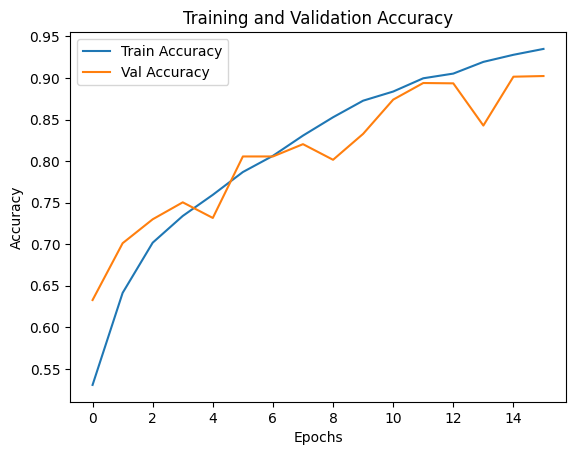

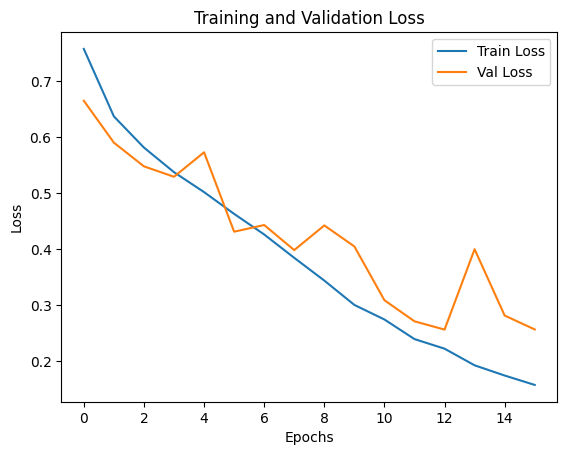

In [11]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [12]:
# Evaluate on Test Set
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc:.4f}")
print(f" Validation Loss: {loss:.4f}")

     74/Unknown 2s 23ms/step - accuracy: 0.8703 - loss: 0.2970

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8707 - loss: 0.2968
Test Accuracy: 0.8798
 Validation Loss: 0.2900


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


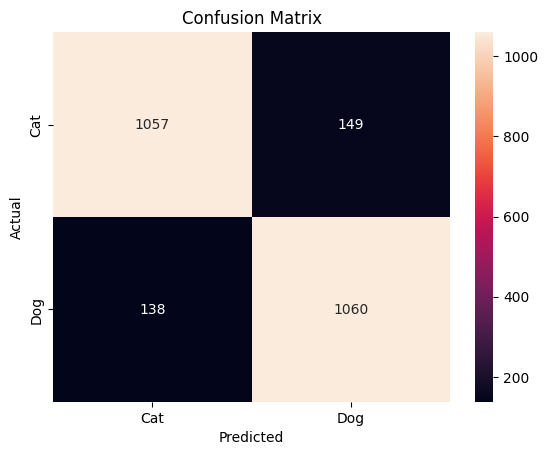

              precision    recall  f1-score   support

         Cat       0.88      0.88      0.88      1206
         Dog       0.88      0.88      0.88      1198

    accuracy                           0.88      2404
   macro avg       0.88      0.88      0.88      2404
weighted avg       0.88      0.88      0.88      2404



In [13]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = (preds > 0.5).astype(int).flatten()
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=['Cat', 'Dog']))


Image 1 - Original range: [0.000, 248.625]
Image 2 - Original range: [0.000, 255.000]
Image 3 - Original range: [3.580, 254.653]
Image 4 - Original range: [0.000, 205.500]
Image 5 - Original range: [0.833, 214.583]
Image 6 - Original range: [1.167, 255.000]
Image 7 - Original range: [0.000, 247.946]
Image 8 - Original range: [0.000, 239.176]
Image 9 - Original range: [0.000, 243.326]


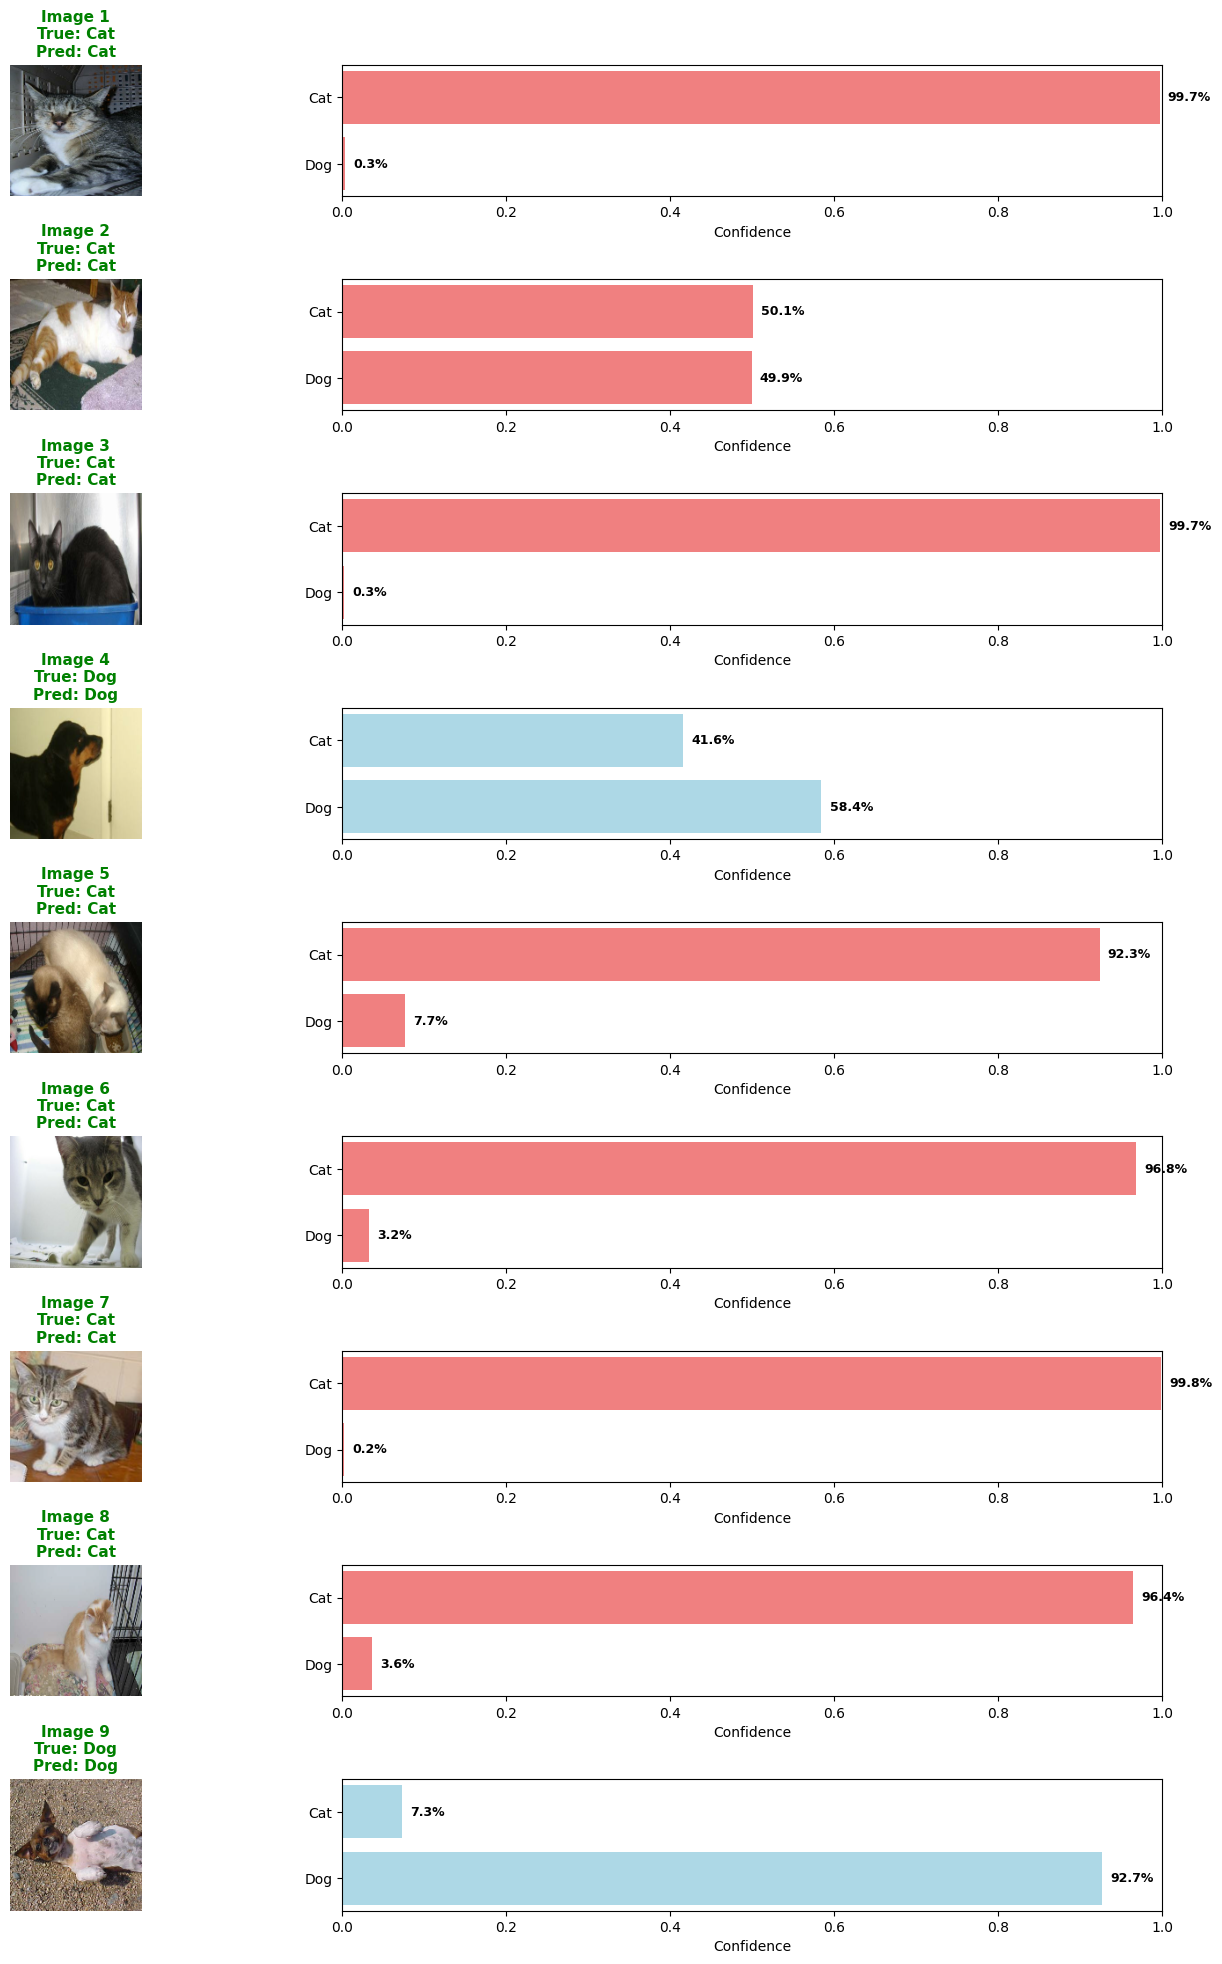

In [14]:
# Class names
class_names = ['Cat', 'Dog']

# Get 9 images from test dataset
for images, labels in test_ds.take(1):
    images = images[:9]
    labels = labels[:9]
    images_np = images.numpy()
    labels_np = labels.numpy()
    break

# Predict
preds = model.predict(images, verbose=0).flatten()
pred_classes = (preds > 0.5).astype(int)
true_classes = labels_np.astype(int)

# Plot with improved image display
plt.figure(figsize=(16, 20))

for i in range(9):
    # ----------- Image (LEFT SIDE) ------------
    plt.subplot(9, 2, 2*i + 1)
    # Properly handle image normalization for display
    img = images_np[i].copy()
    
    # Debug: Check the original range
    print(f"Image {i+1} - Original range: [{img.min():.3f}, {img.max():.3f}]")
    
    # Handle different normalization cases
    if img.min() >= 0 and img.max() <= 1:
        # Already in [0, 1] range
        display_img = img
    elif img.min() >= -1 and img.max() <= 1:
        # Normalized to [-1, 1], convert to [0, 1]
        display_img = (img + 1) / 2
    else:
        # Scale to [0, 1] range
        display_img = (img - img.min()) / (img.max() - img.min())
    
    # Ensure values are in [0, 1] range and convert to uint8 for better display
    display_img = np.clip(display_img, 0, 1)
    
    # If image is grayscale, remove the channel dimension
    if display_img.shape[-1] == 1:
        display_img = display_img.squeeze()
        plt.imshow(display_img, cmap='gray', vmin=0, vmax=1)
    else:
        plt.imshow(display_img, vmin=0, vmax=1)
    
    plt.axis('off')
    
    # Color-coded title based on prediction correctness
    is_correct = pred_classes[i] == true_classes[i]
    title_color = 'green' if is_correct else 'red'
    
    plt.title(f"Image {i+1}\nTrue: {class_names[int(true_classes[i])]}\nPred: {class_names[int(pred_classes[i])]}", 
              color=title_color, fontsize=11, fontweight='bold')

    # ----------- Bar Plot (Cat vs Dog Confidence) ------------
    plt.subplot(9, 2, 2*i + 2)
    probs = [1 - preds[i], preds[i]]  # [Cat prob, Dog prob]
    
    # Color bars based on prediction
    colors = ['lightcoral' if pred_classes[i] == 0 else 'lightblue', 
              'lightblue' if pred_classes[i] == 1 else 'lightcoral']
    bars = plt.barh(class_names, probs, color=colors)
    plt.xlim(0, 1)
    plt.xlabel("Confidence", fontsize=10)
    plt.gca().invert_yaxis()

    # Add percentage labels on bars
    for j, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                 f"{width * 100:.1f}%", va='center', fontsize=9, fontweight='bold')

# Adjust layout for better spacing
plt.tight_layout(pad=2.0)
plt.show()

In [15]:
model.save('cats_dogs_classifier.h5')